## Notebook Overview

This notebook is inspired by [Denny Britz's Basic NN-Implementation](https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb). This is essentially me following along to his notebook, it is easier for me to understand a concept if I follow along the exercise step-by-step. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

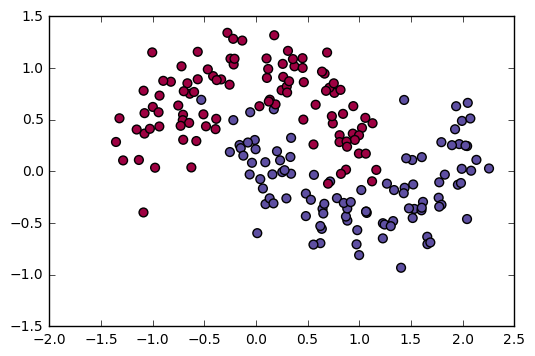

In [2]:
# A random seed for all numpy randomized operations
np.random.seed (0)

# Makes two interleaving half-circles based on the 
# gaussian distribution
X, y = make_moons (200, noise=0.20)

# Plot the data we generated
plt.scatter (X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show ()

## Logistic Regression

We will now attempt to classify our data using Logistic Regression. The important thing to note in this case, is that the data is not linearly separable thus our intention is to show the difficulty that linear regression will have in coming up with a satisfactory classifier.

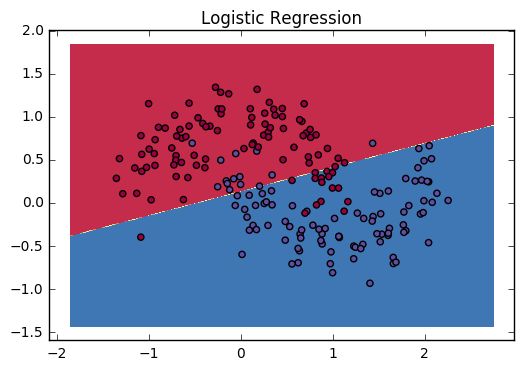

In [3]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV ()
clf.fit (X, y)

def plot_decision_boundary (prediction_function):
    # Set minimum and maximum values for the X and Y axis
    x_min, x_max = X[:,0].min () - 0.5, X[:,0].max () + 0.5
    y_min, y_max = X[:,1].min () - 0.5, X[:,1].max () + 0.5
    
    # Generate a grid of points with distance h between them
    h = 0.01
    xx, yy = np.meshgrid (np.arange (x_min, x_max, h), np.arange (y_min, y_max, h))
    
    # We predict the value of our function throughout the entire grid
    Z = prediction_function (np.c_[xx.ravel (), yy.ravel ()])
    Z = Z.reshape (xx.shape)
    
    # Plot the contour's (decision boundary) and training examples
    plt.contourf (xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter (X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

plot_decision_boundary (lambda x: clf.predict (x))
plt.title("Logistic Regression")
plt.show ()

## Basic Neural Network

TODO RARS

In [4]:
# Get the number of examples in our training set
num_examples = len (X)

# Variables for input and output dimensions
nn_input_dim = 2
nn_output_dim = 2

# Regularization Parameters
reg_lambda = 0.01

In [5]:
def calculate_loss (model):
    W1, W2, W3, W4, W5 = model["W1"], model["W2"], model["W3"], model["W4"], model["W5"]
    b1, b2, b3, b4, b5 = model["b1"], model["b2"], model["b3"], model["b4"], model["b5"]
    
    #===============Hidden Layer===============#
    z1 = X.dot (W1) + b1
    a1 = 1./(1 + np.exp (-z1))
    
    z2 = a1.dot (W2) + b2
    a2 = 1./(1 + np.exp (-z2))
    
    z3 = a2.dot (W3) + b3
    a3 = 1./(1 + np.exp (-z3))
    
    z4 = a3.dot (W4) + b4
    a4 = 1./(1 + np.exp (-z4))
    
    #===============Output Layer===============#
    z5 = a4.dot (W5) + b5
    
    # Softmax Calculation
    exp_scores = np.exp (z5)
    probs = exp_scores / np.sum (exp_scores, axis=1, keepdims=True)
    
    # Cross-Entropy Loss
    correct_logprobs = -np.log (probs[range (num_examples), y])
    data_loss = np.sum (correct_logprobs)
    
    # Regularization Parameter
    data_loss += reg_lambda/5 * (np.sum (np.square (W1)) + np.sum (np.square (W2)) \
                                 + np.sum (np.square (W3)) + np.sum (np.square (W4)) \
                                 + np.sum (np.square (W5)))
    return 1./num_examples * data_loss

In [6]:
def predict (model, X):
    W1, W2, W3, W4, W5 = model["W1"], model["W2"], model["W3"], model["W4"], model["W5"]
    b1, b2, b3, b4, b5 = model["b1"], model["b2"], model["b3"], model["b4"], model["b5"]
    
    #===============Hidden Layer===============#
    z1 = X.dot (W1) + b1
    a1 = 1./(1 + np.exp (-z1))
    
    z2 = a1.dot (W2) + b2
    a2 = 1./(1 + np.exp (-z2))
    
    z3 = a2.dot (W3) + b3
    a3 = 1./(1 + np.exp (-z3))
    
    z4 = a3.dot (W4) + b4
    a4 = 1./(1 + np.exp (-z4))
    
    #===============Output Layer===============#
    z5 = a4.dot (W5) + b5
    
    # Softmax Calculation
    exp_scores = np.exp (z5)
    probs = exp_scores / np.sum (exp_scores, axis=1, keepdims=True)
    return np.argmax (probs, axis=1)

In [7]:
def build_model (nn_hdim, num_passes=20000, learning_rate = 0.01, stochastic=False, mini_batch=False, print_loss=False):
    # Initialize parameters to random values
    np.random.seed (43)

    W1 = np.random.randn (nn_input_dim, nn_hdim) / np.sqrt (nn_input_dim)
    b1 = np.zeros ((1, nn_hdim))
    
    W2 = np.random.randn (nn_hdim, nn_hdim) / np.sqrt (nn_hdim)
    b2 = np.zeros ((1, nn_hdim))
    
    W3 = np.random.randn (nn_hdim, nn_hdim) / np.sqrt (nn_hdim)
    b3 = np.zeros ((1, nn_hdim))
    
    W4 = np.random.randn (nn_hdim, nn_hdim) / np.sqrt (nn_hdim)
    b4 = np.zeros ((1, nn_hdim))
    
    W5 = np.random.randn (nn_hdim, nn_output_dim) / np.sqrt (nn_hdim)
    b5 = np.zeros ((1, nn_output_dim))
    
    model = {}
    
    for i in xrange (0, num_passes):
        #=======================Mini-Batch=======================#
        # Regular Gradient-Descent updates the parameters by doing
        # backpropagation on the entire dataset. Mini-Batch simply
        # samples from the training-set and updates based on that
        # sample. It is more computationally efficient to do so
        # and we get a good approximation of the gradient loss.
        if mini_batch:
            # Use 10% of the dataset as our batch_size
            batch_size = int (num_examples * 0.10)
            num_examples_batch = batch_size
            
            batch_idx = np.random.choice (len (X), batch_size, replace=False)
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
        #=======================Stochastic=======================#
        # Stochastic Gradient Descent is very similar to Mini-Batch
        # gradient descent, but in this case our batch size is 1
        elif stochastic:
            num_examples_batch = 1
            batch_idx = np.random.choice (len(X))
        else:
            # Treat the whole dataset as our batch
            num_examples_batch = num_examples
            X_batch = X
            y_batch = y
        
        #=======================Learning-Rate-Adaptation=======================#
        # Reduce the learning rate by half every 20 iterations, there are other
        # methods for doing this such as exponential decay or 1/t decay.
        # http://cs231n.github.io/neural-networks-3/#anneal
        if i+1 % 20 == 0:
            # We need to be careful, it is possible that our learning rate
            # goes down to zero. Here, we just keep the current learning rate
            # if that happens.
            if learning_rate / 2 == 0:
                pass
            else:
                learning_rate /= 2
        #=======================Learning-Rate-Adaptation=======================#
        
        #===============Hidden Layer===============#
        z1 = X.dot (W1) + b1
        a1 = 1./(1 + np.exp (-z1))

        z2 = a1.dot (W2) + b2
        a2 = 1./(1 + np.exp (-z2))

        z3 = a2.dot (W3) + b3
        a3 = 1./(1 + np.exp (-z3))

        z4 = a3.dot (W4) + b4
        a4 = 1./(1 + np.exp (-z4))

        #===============Output Layer===============#
        z5 = a4.dot (W5) + b5
    
        # Softmax Calculation
        exp_scores = np.exp (z5)
        probs = exp_scores / np.sum (exp_scores, axis=1, keepdims=True)
        
        delta6 = probs
        delta6[range(num_examples), y] -= 1
        dW5 = (a4.T).dot (delta6)
        db5 = np.sum (delta6, axis=0, keepdims=True)
        
        delta5 = delta6.dot (W5.T) * ((1 - a4) * a4)
        dW4 = (a3.T).dot (delta5)
        db4 = np.sum (delta5, axis=0, keepdims=True)
        
        delta4 = delta5.dot (W4.T) * ((1 - a3) * a3)
        dW3 = (a2.T).dot (delta4)
        db3 = np.sum (delta4, axis=0, keepdims=True)
        
        delta3 = delta4.dot (W3.T) * ((1 - a2) * a2)
        dW2 = (a1.T).dot (delta3)
        db2 = np.sum (delta3, axis=0, keepdims=True)
        
        delta2 = delta3.dot (W2.T) * ((1 - a1) * a1)
        dW1 = np.dot (X.T, delta2)
        db1 = np.sum (delta2, axis=0, keepdims=True)
        
        # Calculate regularization 
        dW5 += reg_lambda * W5
        dW4 += reg_lambda * W4
        dW3 += reg_lambda * W3
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # Gradient descent simultaneous update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
        W3 += -learning_rate * dW3
        b3 += -learning_rate * db3
        W4 += -learning_rate * dW4
        b4 += -learning_rate * db4
        W5 += -learning_rate * dW5
        b5 += -learning_rate * db5
        
        # Update Model
        model = {"W1" : W1, "W2" : W2, "W3" : W3, "W4" : W4, "W5" : W5,
                 "b1" : b1, "b2" : b2, "b3" : b3, "b4" : b4, "b5" : b5}
        
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %d : %f" % (i, calculate_loss (model))
            
    return model

Loss after iteration 0 : 0.699999
Loss after iteration 1000 : 0.313383
Loss after iteration 2000 : 0.297191
Loss after iteration 3000 : 0.296245
Loss after iteration 4000 : 0.299316
Loss after iteration 5000 : 0.284499
Loss after iteration 6000 : 0.277469
Loss after iteration 7000 : 0.268762
Loss after iteration 8000 : 0.258869
Loss after iteration 9000 : 0.258422
Loss after iteration 10000 : 0.258170
Loss after iteration 11000 : 0.257478
Loss after iteration 12000 : 0.269294
Loss after iteration 13000 : 0.259356
Loss after iteration 14000 : 0.133382
Loss after iteration 15000 : 0.129934
Loss after iteration 16000 : 0.115269
Loss after iteration 17000 : 0.140048
Loss after iteration 18000 : 0.119723
Loss after iteration 19000 : 0.112816


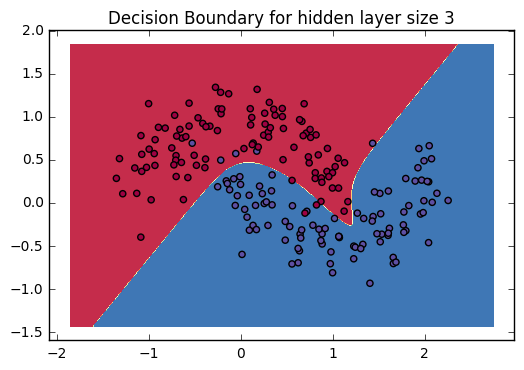

In [8]:
model = build_model (2, print_loss=True, stochastic=True)

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show ()

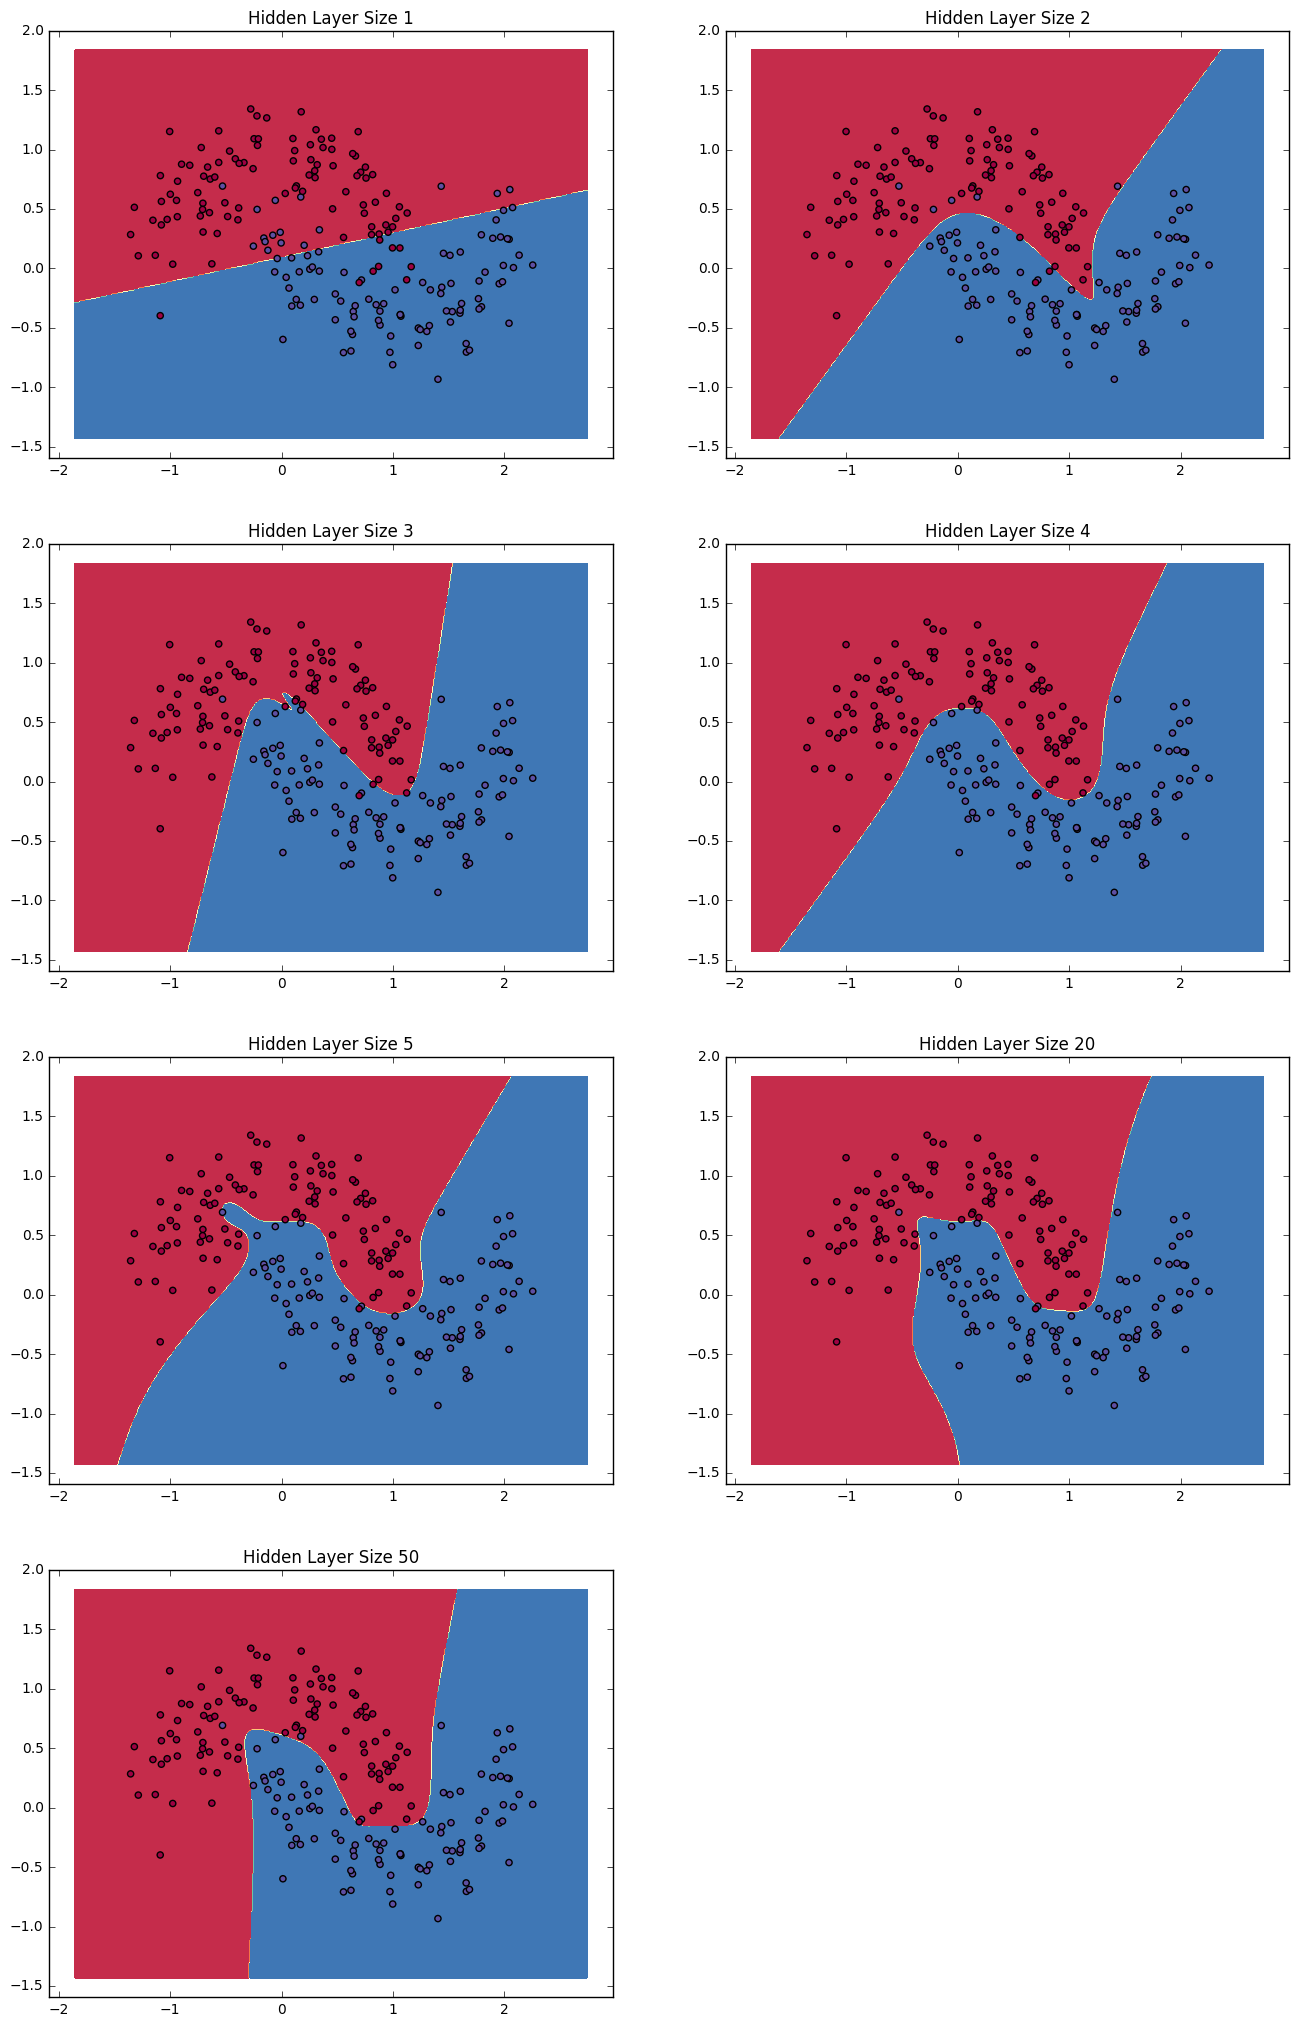

In [9]:
plt.figure (figsize=(16,32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate (hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title("Hidden Layer Size %d" % nn_hdim)
    model = build_model (nn_hdim, stochastic=True)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show ()